In [1]:
import gym
import numpy as np
import tensorflow as tf
from tensorflow.contrib import slim

import os
import random
import itertools

import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
%matplotlib inline

In [2]:
env = gym.make('Acrobot-v1')
n_features = env.observation_space.shape[0]
n_actions = env.action_space.n

[2016-12-24 19:18:21,213] Making new env: Acrobot-v1


In [3]:
class Approximator():
    ''' Creates an ANN to aporoximate Q values '''
    
    def __init__(self, n_features, n_actions, hidden_size, learning_rate=1e-2,
                 clip_grads=False, scope='main', summary_name=None):
        self.summary_writer = None 
        self.scope = scope
        with tf.variable_scope(self.scope):
            self.build(n_features, n_actions, hidden_size, learning_rate, clip_grads)                   
            if summary_name:
                # Make summary dir        
                if not os.path.exists('summary'):
                    os.mkdir('summary')
                self.summary_writer = tf.train.SummaryWriter('summary/DQN/{}'.format(summary_name))                     
        
    def build(self, n_features, n_actions, hidden_size, learning_rate, clip_grads):        
        # Placeholders
        self.X = tf.placeholder(name='input', shape=[None, n_features], dtype=tf.float32)
        self.Y = tf.placeholder(name='target', shape=[None], dtype=tf.float32)
        self.action = tf.placeholder(name='chosen_action', shape=[None], dtype=tf.int32)
        # Stores the time step
        self.global_step = tf.Variable(0, name='global_step', trainable=False)        

        # Network body
        self.hidden = slim.fully_connected(inputs=self.X, num_outputs=hidden_size, activation_fn=tf.nn.sigmoid)
        self.hidden = slim.fully_connected(inputs=self.hidden, num_outputs=hidden_size, activation_fn=tf.nn.relu)
        self.Q = slim.fully_connected(inputs=self.hidden, num_outputs=n_actions, activation_fn=None)
               
        if self.scope == 'main':
            # Loss
            # Get the action value only for the chosen action
            batch_size = tf.shape(self.X)[0]
            action_ids = tf.range(batch_size) * tf.shape(self.Q)[1] + self.action
            self.actions_value = tf.gather(tf.reshape(self.Q, [-1]), action_ids)
            # Use the mean squared error
            self.loss = tf.reduce_mean(tf.squared_difference(self.Y, self.actions_value))
            # Compute and apply gradients
            self.opt = tf.train.AdamOptimizer(learning_rate)
            self.grads_and_vars = self.opt.compute_gradients(self.loss)
            self.clipped_grads = [(tf.clip_by_value(grad, -1, 1), var) for grad, var
                                 in self.grads_and_vars]
            self.train_op = self.opt.apply_gradients(self.clipped_grads, self.global_step)            
            # Tensorboard summaries
            self.summaries = tf.merge_summary([
                    tf.histogram_summary('q_values', self.Q),
                    tf.scalar_summary('max_q_values', tf.reduce_max(self.Q)),
                    tf.scalar_summary('loss', self.loss),               
                ])
        # Target network dont need to compute loss
        else:
            self.train_op = None           
       

    def predict(self, sess, state):
        ''' Calculate Q value '''
        return sess.run(self.Q, feed_dict={self.X:state})  

    def update(self, sess, state, action, target):
        ''' Update weights and write summary '''
        feed_dict = {self.X:state, self.action:action, self.Y:target}
        sess.run(self.train_op, feed_dict=feed_dict)  
        step = sess.run(self.global_step)
        if self.summary_writer and step % 1000 == 0:
            summary = sess.run(self.summaries, feed_dict=feed_dict)
            self.summary_writer.add_summary(summary, step)      

In [4]:
class Replay_Memory():
    ''' Stores states and transitions used to train the network '''
    def __init__(self, limit=200000):
        self.memory = []
        self.limit = limit
        
    def add(self, state, action, reward, next_state, done):
        ''' Adds a new experience to memory '''
        if len(self.memory) == self.limit:
            self.memory.pop(0)
        self.memory.append((state, action, reward, next_state, done))
        
    def sample(self, batch_size):
        ''' Returns random experiences '''
        return random.sample(self.memory, batch_size)      

In [5]:
def update_target_op(main, target, tau):
    ''' 
    Update target network to be "tau" times closer to the learning one
    The target network has to be defined last
    '''
    # Get trainable variables from main and target network
    main_vars = [var for var in tf.trainable_variables() if var.name.startswith(main.scope)]
    target_vars = [var for var in tf.trainable_variables() if var.name.startswith(target.scope)]
    # Get the operations that update target network
    op_holder = []
    for main_var, target_var in zip(main_vars, target_vars):
        op_holder.append(target_var.assign(main_var.value() * tau)
                        + (1 - tau) * target_var.value())
    
    def update_target(sess):
        sess.run(op_holder)
        
    return update_target

In [6]:
def epolicy(Q, epsilon):
    ''' Make an epsilon greedy choice '''   
    A = (np.ones(n_actions) * epsilon) / n_actions
    best_action = np.argmax(np.squeeze(Q))
    A[best_action] += (1 - epsilon)    
    return A

In [7]:
def test_updates(n_updates=100, batch_size=100, learning_rate=3e-4):
    ''' Test if weights updates are affecting mostly the chosen action '''
    tf.reset_default_graph()
    test = Approximator(n_features, n_actions, 10, learning_rate)
    states = [env.observation_space.sample() for _ in range(batch_size)]
    targets = 10 * np.ones(batch_size)
    for action in range(n_actions):
        Q_diff = []
        actions = action * np.ones(batch_size)
        # Reinitialize model for each action because ADAM optimizer builds momentum
        with tf.Session() as sess:
            tf.initialize_all_variables().run()
            for _ in range(n_updates):
                Q_old = np.mean(test.predict(sess, states), axis=0)
                test.update(sess, states, actions, targets)
                Q_new = np.mean(test.predict(sess, states), axis=0)
                Q_diff.append(Q_new - Q_old)
            print('Action {}: {}'.format(action, np.sum(Q_diff, axis=0)))

In [8]:
def convolve(x, window_size):
    ''' Take the mean of array over window '''
    weigths = np.repeat(1.0, window_size) / window_size
    return np.convolve(np.mean(x, axis=0), weigths, 'same')

In [9]:
test_updates()

/home/quazar/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/gradients.py:90: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Action 0: [ 0.62943149  0.12110591  0.27560326]
Action 1: [ 0.01603967  0.28062344 -0.02925068]
Action 2: [-0.29598251  0.09447726  0.40029478]


In [10]:
def train(n_episodes, learning_rate, stop_exploration, discount_factor=0.99,
          epsilon_max=1, epsilon_min=0.01, tau=1e-3, hidden_size=16, clip_grads=False,
          batch_size=32, min_replays=10000, update_step=1000, summary=None):
    
    # Create the network to approximate Q function
    tf.reset_default_graph()
    Q_main = Approximator(n_features, n_actions, hidden_size, learning_rate,
                          clip_grads=clip_grads, summary_name=summary)
    Q_target = Approximator(n_features, n_actions, hidden_size, learning_rate,
                            clip_grads=clip_grads, scope='target')
    # Create operation that update target network
    update_op = update_target_op(Q_main, Q_target, tau)
    
    # Store episodes length
    ep_length = []
    # Calculate epislon step size
    epsilon_step = -np.log(epsilon_min) / stop_exploration
    
    # Create experience replay
    replays = Replay_Memory()
    state = env.reset()
    # Fill replay memory with random actions
    action_probs = np.ones(n_actions) / n_actions
    for _ in range(min_replays):
        action = np.random.choice(np.arange(n_actions), p=action_probs)
        next_state, reward, done, _ = env.step(action)
        # Record experience
        replays.add(state, action, reward, next_state, done)
        # Update state
        state = next_state
        if done:
            state = env.reset()    

    with tf.Session() as sess:
        tf.initialize_all_variables().run()
        update_op(sess)
        # Total frames the agent has seem
        t_sum = 0

        for i_episode in range(n_episodes):
            state = env.reset()
            # Exponentially decay epsilon
            epsilon = epsilon_min + (epsilon_max - epsilon_min) * np.exp(-epsilon_step * i_episode)            

            # Repeat until episode is finished
            for t in itertools.count():
                # Choose an action
                Q = Q_main.predict(sess, [state])
                action_probs = epolicy(Q, epsilon)   
                action = np.random.choice(np.arange(n_actions), p=action_probs)
                # Do the action
                next_state, reward, done, _ = env.step(action)
                # Record experience
                replays.add(state, action, reward, next_state, done)

                # Get replays to train on
                b_state, b_action, b_reward, b_next_state, b_done = map(np.array, zip(*replays.sample(batch_size)))
                # Generate td_targets (target is only the reward if done)
                Q_next = Q_target.predict(sess, b_next_state)
                Q_next_max = np.max(Q_next, axis=1)
                b_td_targets = b_reward + np.bitwise_xor(b_done, 1) * (discount_factor * Q_next_max)
                # Update weights
                Q_main.update(sess, b_state, b_action, b_td_targets)

                # Update state and please, dont equilibrate forever        
                if done:
                    break
                state = next_state
                
                # Update target network
                t_sum += 1
                if t_sum % update_step == 0:
                    update_op(sess)
            
            # Add episode length to tensorboard
            if summary is not None:                
                episode_summary = tf.Summary()
                episode_summary.value.add(simple_value=t, tag='Episode length')
                Q_main.summary_writer.add_summary(episode_summary, i_episode)

            # Store and print information
            ep_length.append(t)
            print('\rEpisode {}/{} | Length: {}'.format(i_episode+1, n_episodes, t), end='', flush=True)
            
    return ep_length

In [11]:
eps_unclipped = [train(n_episodes=1000, learning_rate=3e-4, stop_exploration=500, clip_grads=False,
                    tau=1, update_step=5000, summary='unclipped_{}'.format(i)) for i in range(10)]

/home/quazar/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/gradients.py:90: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Episode 1000/1000 | Length: 79

In [12]:
eps_clipped = [train(n_episodes=1000, learning_rate=3e-4, stop_exploration=500, clip_grads=True,
                            tau=1, update_step=5000, summary='clipped_{}'.format(i)) for i in range(10)] 

/home/quazar/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/gradients.py:90: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Episode 1000/1000 | Length: 390

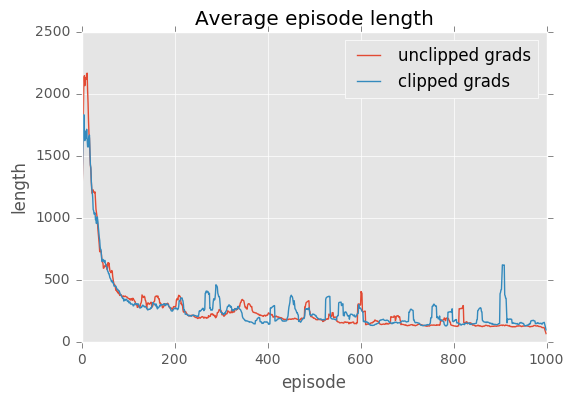

In [13]:
# Plot episodes length smoothed over a window size of 10
plt.plot(convolve(eps_unclipped, 10), label='unclipped grads')
plt.plot(convolve(eps_clipped, 10), label='clipped grads')
plt.title('Average episode length')
plt.xlabel('episode')
plt.ylabel('length')
plt.legend()